In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, utils, callbacks
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler, LabelEncoder


In [13]:
df = pd.read_csv("3) Sentiment dataset.csv")

data_df = df.copy()
X = data_df.iloc[:, :-1].copy()
y_raw = data_df.iloc[:, -1].copy()

le_target = LabelEncoder()
y = le_target.fit_transform(y_raw)
n_classes = len(np.unique(y))

text_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

if len(text_cols) > 0 and len(num_cols) == 0:
    text_col = text_cols[0]
    corpus = X[text_col].astype(str).tolist()
    vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
    X_trans = vectorizer.fit_transform(corpus)
    svd_n = min(300, X_trans.shape[1]-1) if X_trans.shape[1] > 1 else 1
    if svd_n >= 1:
        svd = TruncatedSVD(n_components=svd_n, random_state=42)
        X_reduced = svd.fit_transform(X_trans)
    else:
        X_reduced = X_trans.toarray()
    X_final = X_reduced
    is_sparse = False
else:
    for c in X.select_dtypes(include=['object']).columns:
        X[c] = LabelEncoder().fit_transform(X[c].astype(str))
    scaler = StandardScaler()
    X_final = scaler.fit_transform(X)
    is_sparse = False

counts = pd.Series(y).value_counts()
min_count = counts.min()

if min_count >= 2:
    X_train, X_test, y_train, y_test = train_test_split(
        X_final, y, test_size=0.2, random_state=42, stratify=y
    )
else:
    X_train, X_test, y_train, y_test = train_test_split(
        X_final, y, test_size=0.2, random_state=42, shuffle=True
    )

if n_classes > 2:
    y_train_cat = utils.to_categorical(y_train, n_classes)
    y_test_cat = utils.to_categorical(y_test, n_classes)
else:
    y_train_cat = y_train
    y_test_cat = y_test

input_shape = X_train.shape[1]

print("n_classes:", n_classes)
import collections
print("Train class counts:", collections.Counter(y_train))
print("Test  class counts:", collections.Counter(y_test))
print("X_train shape:", X_train.shape, "X_test shape:", X_test.shape)
try:
    print("y_train_cat shape:", y_train_cat.shape, "y_test_cat shape:", y_test_cat.shape)
except:
    print("y_train_cat not available or not numpy")
model.summary()


n_classes: 22
Train class counts: Counter({12: 79, 17: 65, 14: 61, 16: 48, 15: 38, 18: 36, 13: 32, 10: 32, 19: 31, 9: 28, 20: 26, 11: 25, 8: 24, 7: 20, 6: 20, 5: 7, 21: 6, 4: 3, 2: 2, 0: 1, 3: 1})
Test  class counts: Counter({16: 17, 12: 15, 13: 15, 18: 14, 19: 10, 17: 10, 15: 10, 9: 9, 7: 8, 14: 8, 20: 7, 10: 6, 8: 6, 11: 5, 6: 3, 1: 1, 21: 1, 4: 1, 2: 1})
X_train shape: (585, 14) X_test shape: (147, 14)
y_train_cat shape: (585, 22) y_test_cat shape: (147, 22)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         3,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 22)             │         2,838 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,724 (463.77 KB)

 Trainable params: 39,574 (154.59 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 79,150 (309.18 KB)

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

log = LogisticRegression(max_iter=2000, class_weight="balanced", n_jobs=-1)
log.fit(X_train, y_train)
y_pred = log.predict(X_test)
print("Baseline LogisticRegression acc:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Baseline LogisticRegression acc: 0.06802721088435375
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         1
           2       0.10      1.00      0.18         1
           3       0.00      0.00      0.00         0
           4       0.10      1.00      0.18         1
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         3
           7       0.38      0.38      0.38         8
           8       0.25      0.17      0.20         6
           9       0.00      0.00      0.00         9
          10       0.11      0.17      0.13         6
          11       0.00      0.00      0.00         5
          12       0.00      0.00      0.00        15
          13       0.12      0.07      0.09        15
          14       0.00      0.00      0.00         8
          15       0.14      0.10      0.12        10
          16       0.00     

c:\Users\Madesh\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Madesh\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Madesh\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Madesh\miniconda3\Lib\site-packag

In [15]:
from tensorflow.keras import models, layers, callbacks, optimizers
import numpy as np

if n_classes > 2:
    out_units = n_classes
    out_activation = "softmax"
    loss = "categorical_crossentropy"
    y_train_fit = y_train_cat
    y_test_fit = y_test_cat
else:
    out_units = 1
    out_activation = "sigmoid"
    loss = "binary_crossentropy"
    y_train_fit = y_train
    y_test_fit = y_test

model = models.Sequential()
model.add(layers.Input(shape=(input_shape,)))
model.add(layers.Dense(512, activation="relu"))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.15))
model.add(layers.Dense(out_units, activation=out_activation))

opt = optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])
es = callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True)

history = model.fit(
    X_train, y_train_fit,
    validation_split=0.15,
    epochs=50,
    batch_size=32,
    callbacks=[es],
    verbose=2
)

model.summary()


Epoch 1/50
16/16 - 2s - 109ms/step - accuracy: 0.1046 - loss: 2.8798 - val_accuracy: 0.1023 - val_loss: 2.7405
Epoch 2/50
16/16 - 0s - 12ms/step - accuracy: 0.1811 - loss: 2.5737 - val_accuracy: 0.1477 - val_loss: 2.6375
Epoch 3/50
16/16 - 0s - 10ms/step - accuracy: 0.1549 - loss: 2.4858 - val_accuracy: 0.1136 - val_loss: 2.6191
Epoch 4/50
16/16 - 0s - 9ms/step - accuracy: 0.2133 - loss: 2.4012 - val_accuracy: 0.1705 - val_loss: 2.6067
Epoch 5/50
16/16 - 0s - 10ms/step - accuracy: 0.2656 - loss: 2.3180 - val_accuracy: 0.1477 - val_loss: 2.5892
Epoch 6/50
16/16 - 0s - 10ms/step - accuracy: 0.2656 - loss: 2.2677 - val_accuracy: 0.1250 - val_loss: 2.6031
Epoch 7/50
16/16 - 0s - 14ms/step - accuracy: 0.2877 - loss: 2.1967 - val_accuracy: 0.1364 - val_loss: 2.6251
Epoch 8/50
16/16 - 0s - 9ms/step - accuracy: 0.2837 - loss: 2.1483 - val_accuracy: 0.1136 - val_loss: 2.6395
Epoch 9/50
16/16 - 0s - 11ms/step - accuracy: 0.3078 - loss: 2.1104 - val_accuracy: 0.1364 - val_loss: 2.6260
Epoch 10/50

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 512)            │         7,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 22)             │         5,654 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 433,988 (1.66 MB)

 Trainable params: 144,662 (565.09 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 289,326 (1.10 MB)

In [16]:
res = model.evaluate(X_test, y_test_fit, verbose=0)
print("Test loss/acc:", res)
y_prob = model.predict(X_test)
if n_classes > 2:
    y_pred = np.argmax(y_prob, axis=1)
else:
    y_pred = (y_prob.ravel() >= 0.5).astype(int)

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


Test loss/acc: [2.8469042778015137, 0.0476190485060215]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           6       1.00      0.33      0.50         3
           7       0.14      0.12      0.13         8
           8       0.00      0.00      0.00         6
           9       0.00      0.00      0.00         9
          10       0.00      0.00      0.00         6
          11       0.00      0.00      0.00         5
          12       0.06      0.20      0.09        15
          13       0.00      0.00      0.00        15
          14       0.00      0.00      0.00         8
          15       0.00      0.00      0.00        10
          16       0.00      0.00      0.00        17
          17       0.00      0.00      0.00        10
          18       0.12      0.14      0.

c:\Users\Madesh\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Madesh\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Madesh\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [17]:
es = callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True)
history = model.fit(
    X_train, y_train_cat,
    validation_split=0.15,
    epochs=100,
    batch_size=64,
    callbacks=[es],
    verbose=2
)


Epoch 1/100
8/8 - 0s - 41ms/step - accuracy: 0.2656 - loss: 2.2674 - val_accuracy: 0.1364 - val_loss: 2.6365
Epoch 2/100
8/8 - 0s - 16ms/step - accuracy: 0.2777 - loss: 2.2176 - val_accuracy: 0.1364 - val_loss: 2.6142
Epoch 3/100
8/8 - 0s - 23ms/step - accuracy: 0.2998 - loss: 2.1930 - val_accuracy: 0.1477 - val_loss: 2.6003
Epoch 4/100
8/8 - 0s - 19ms/step - accuracy: 0.3380 - loss: 2.1513 - val_accuracy: 0.1364 - val_loss: 2.6108
Epoch 5/100
8/8 - 0s - 18ms/step - accuracy: 0.3159 - loss: 2.1309 - val_accuracy: 0.1477 - val_loss: 2.6085
Epoch 6/100
8/8 - 0s - 16ms/step - accuracy: 0.3360 - loss: 2.1072 - val_accuracy: 0.1477 - val_loss: 2.6238
Epoch 7/100
8/8 - 0s - 15ms/step - accuracy: 0.3421 - loss: 2.0730 - val_accuracy: 0.1136 - val_loss: 2.6325
Epoch 8/100
8/8 - 0s - 16ms/step - accuracy: 0.3541 - loss: 2.0528 - val_accuracy: 0.0909 - val_loss: 2.6394
Epoch 9/100
8/8 - 0s - 16ms/step - accuracy: 0.3722 - loss: 1.9978 - val_accuracy: 0.1023 - val_loss: 2.6412


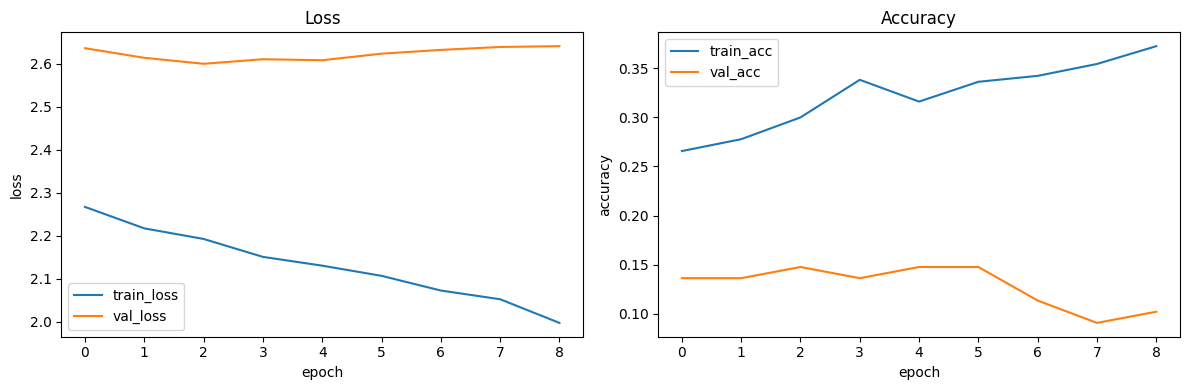

In [18]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.title("Accuracy")
plt.tight_layout()
plt.show()


In [19]:
test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=0)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

y_prob = model.predict(X_test)
if n_classes > 2:
    y_pred = np.argmax(y_prob, axis=1)
else:
    y_pred = (y_prob.ravel() >= 0.5).astype(int)

from sklearn.metrics import classification_report, roc_auc_score
print(classification_report(y_test, y_pred))
if n_classes == 2:
    auc_score = roc_auc_score(y_test, y_prob)
    print("AUC:", auc_score)
else:
    try:
        auc_score = roc_auc_score(utils.to_categorical(y_test, n_classes), y_prob, multi_class="ovr")
        print("Multi-class AUC (OVR):", auc_score)
    except:
        pass


Test loss: 2.863908290863037
Test accuracy: 0.08163265138864517
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           6       0.50      0.33      0.40         3
           7       0.25      0.25      0.25         8
           8       0.00      0.00      0.00         6
           9       0.00      0.00      0.00         9
          10       0.00      0.00      0.00         6
          11       0.00      0.00      0.00         5
          12       0.08      0.20      0.12        15
          13       0.00      0.00      0.00        15
          14       0.05      0.12      0.07         8
          15       0.00      0.00      0.00        10
          16       0.12      0.12      0.12        17
          17       0.09      0.20      0.12        10
          18       0.00      0.00

c:\Users\Madesh\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Madesh\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Madesh\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Madesh\miniconda3\Lib\sit

In [20]:
model.save("nn_classifier_model.keras")
import joblib
joblib.dump(scaler, "scaler.save")


['scaler.save']